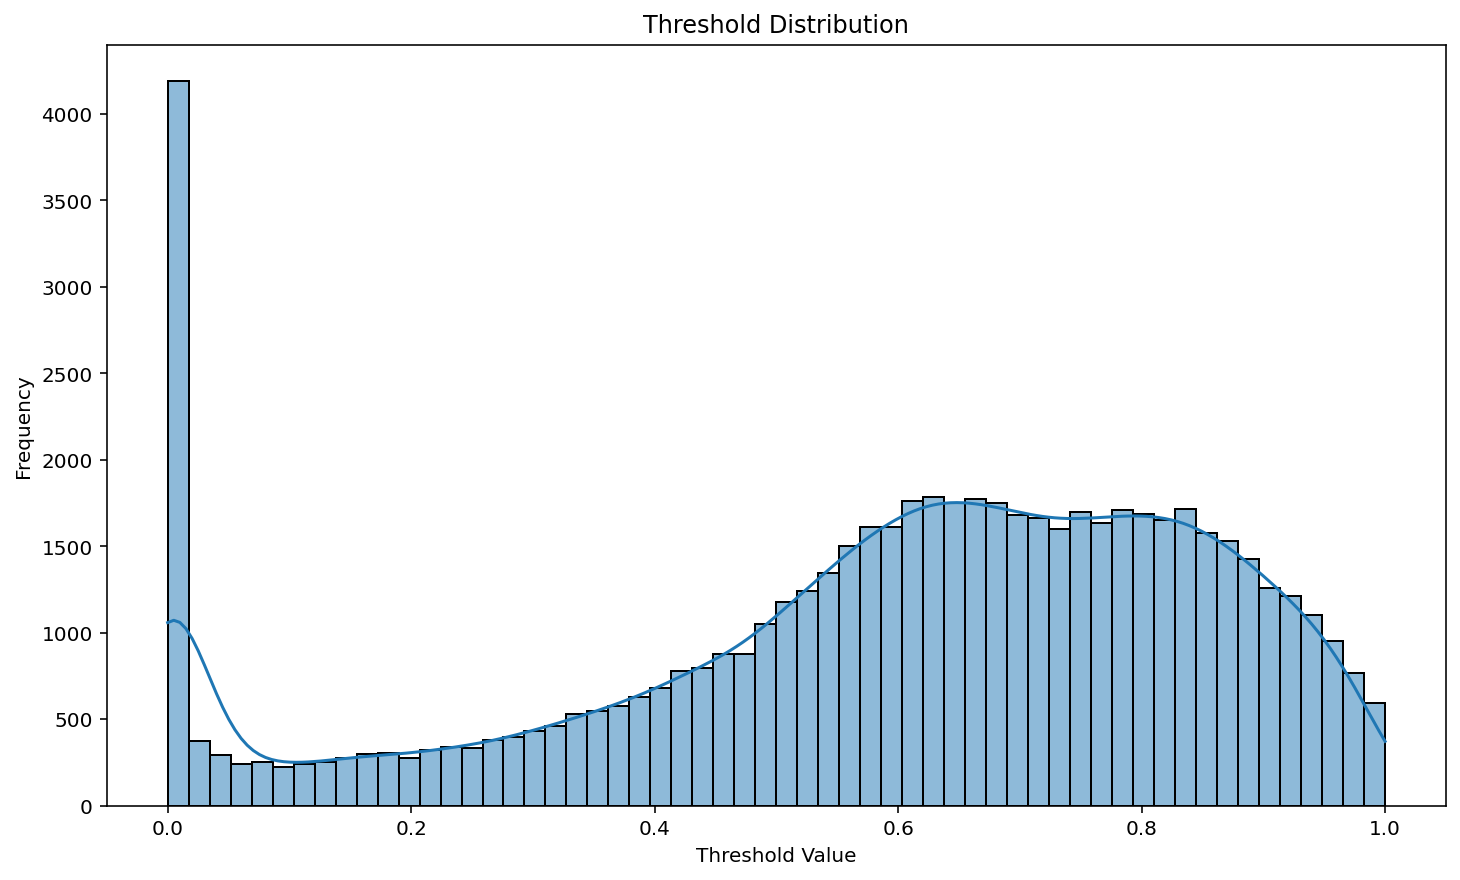

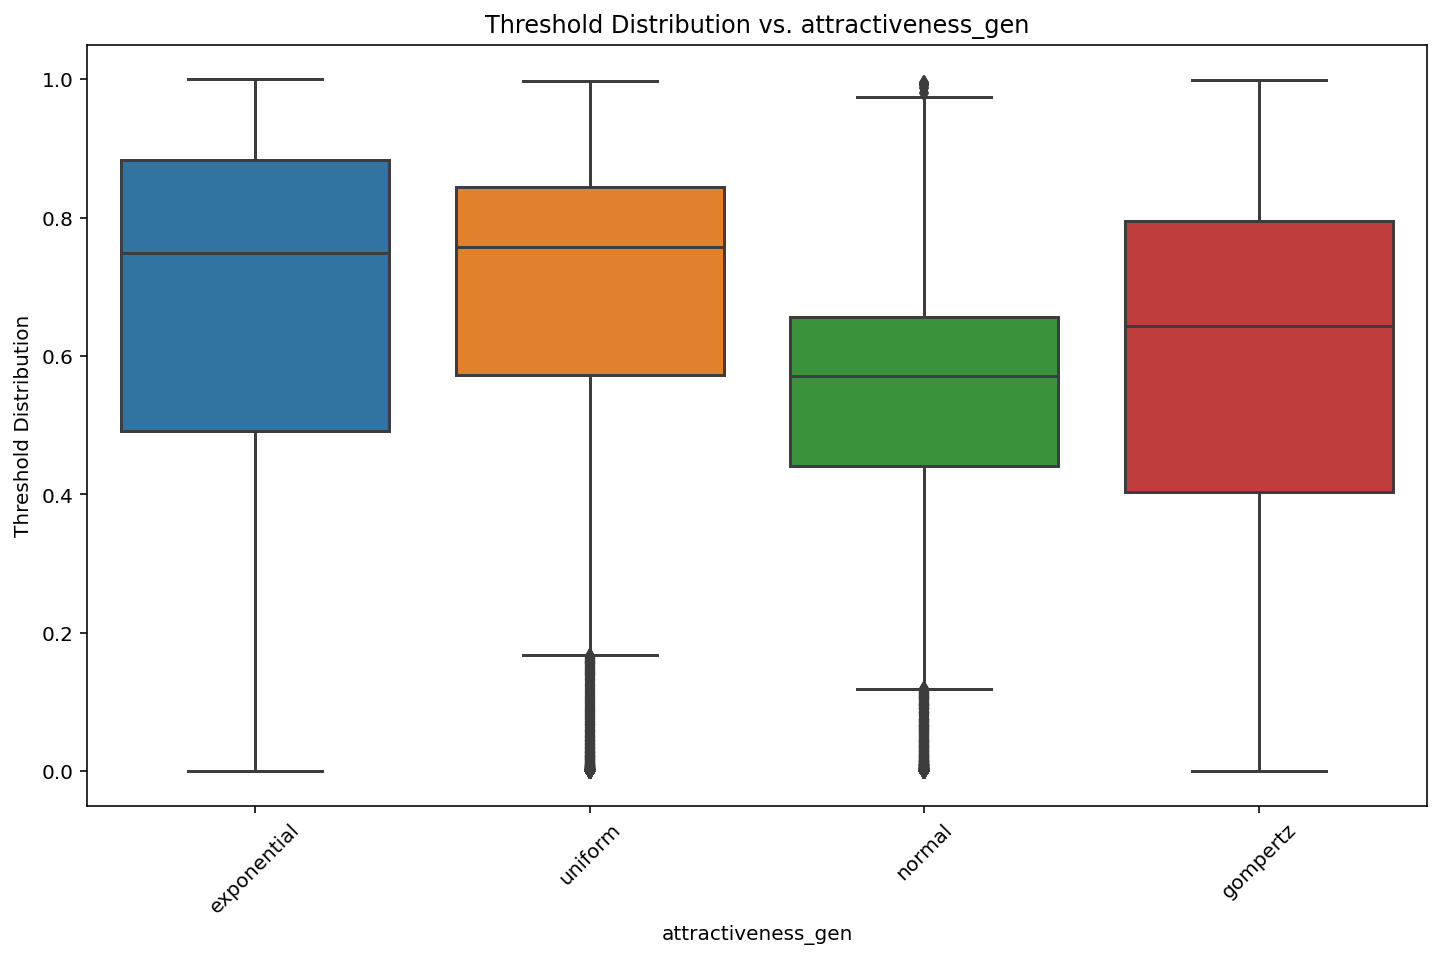

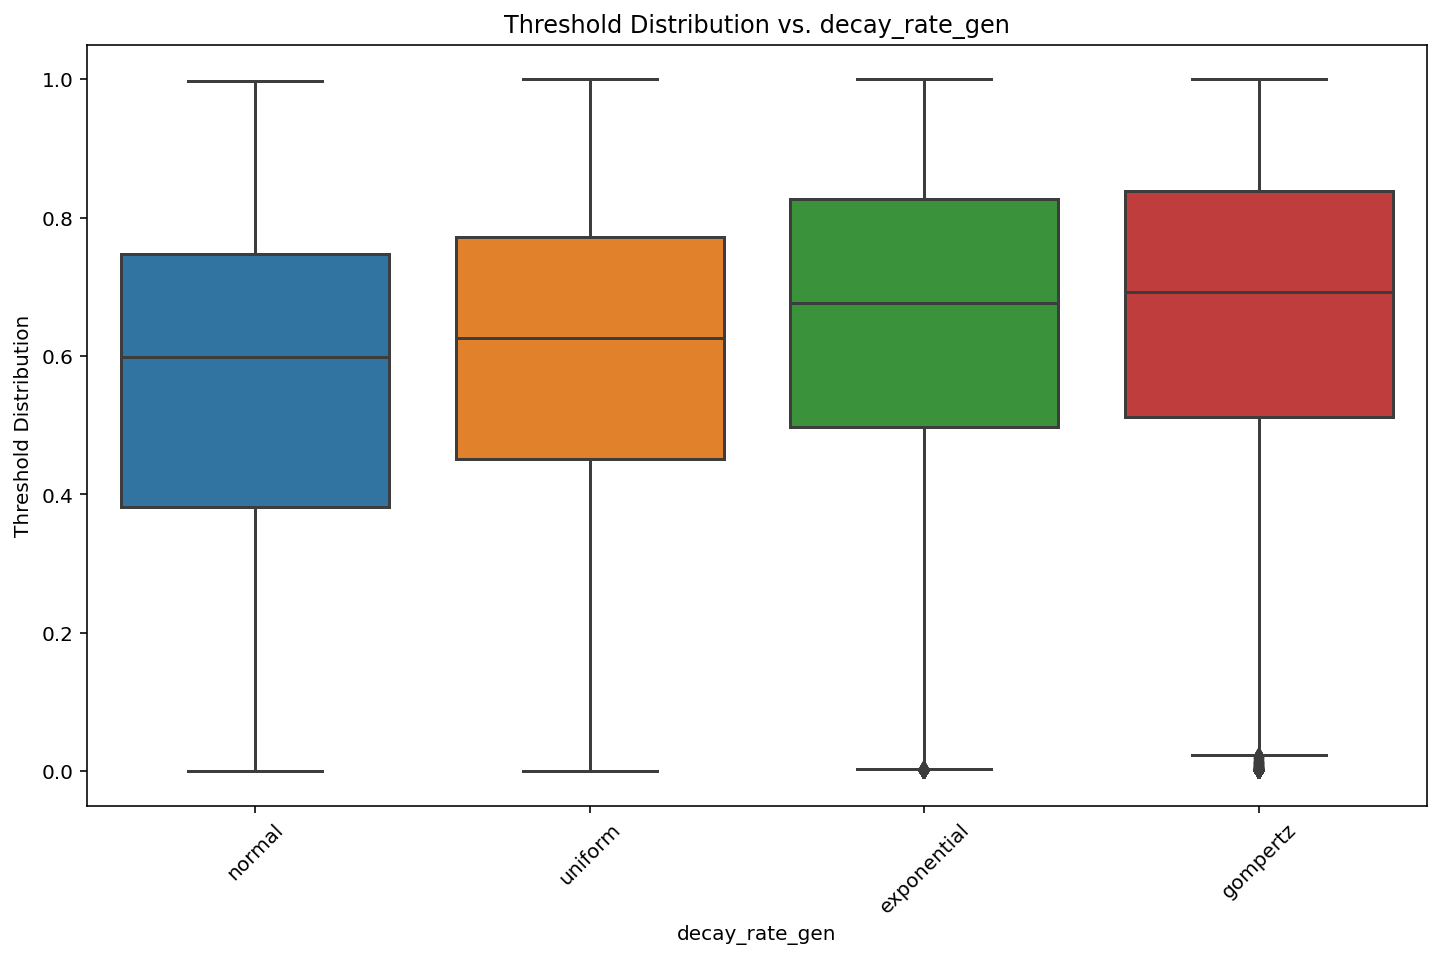

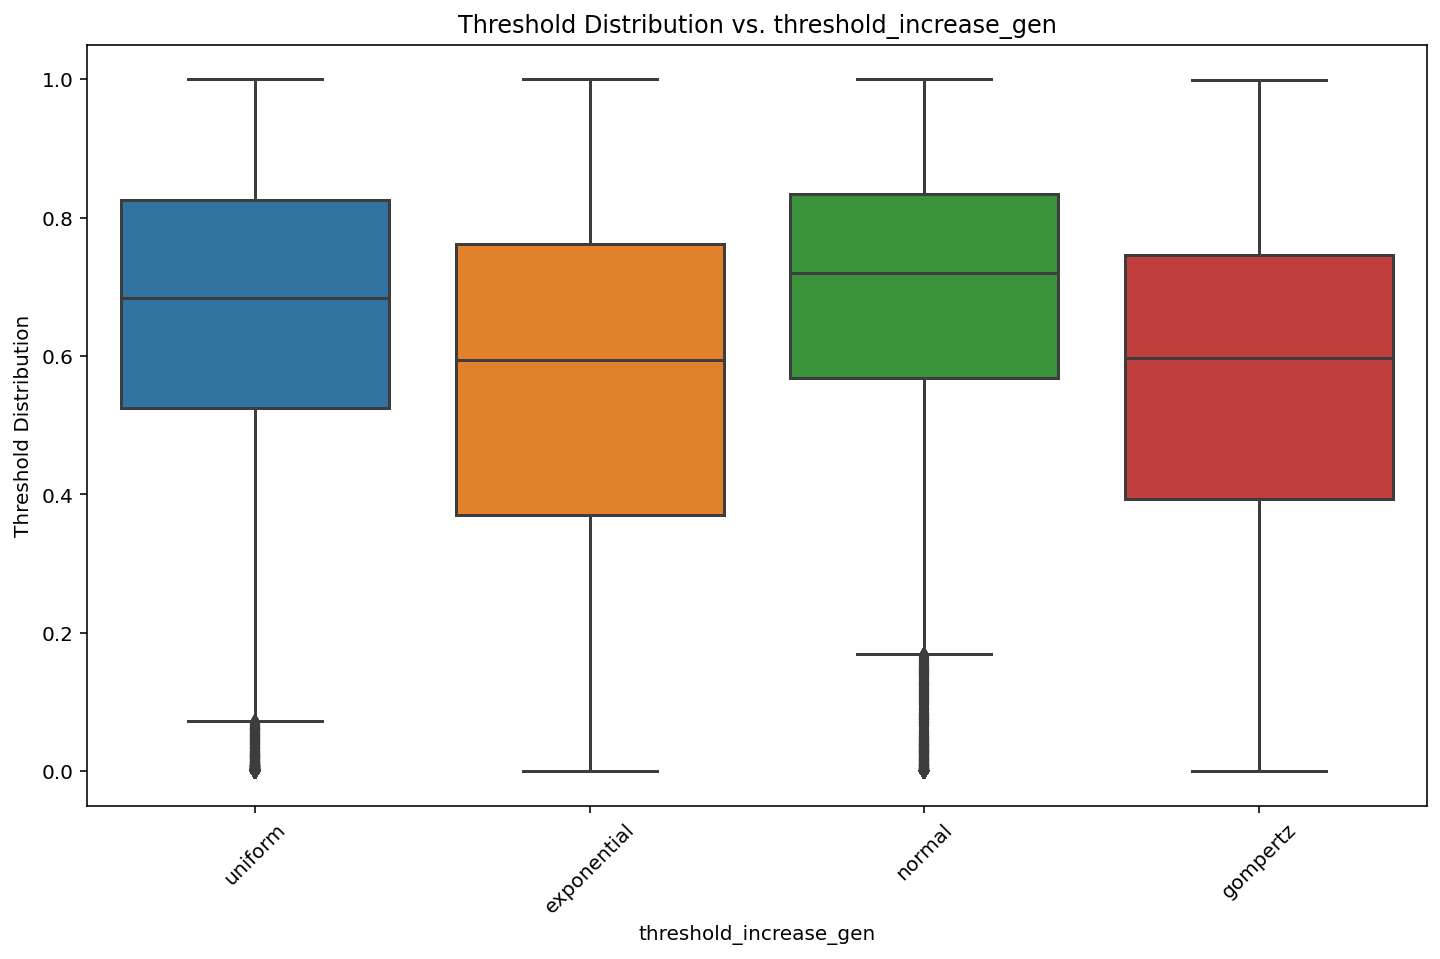

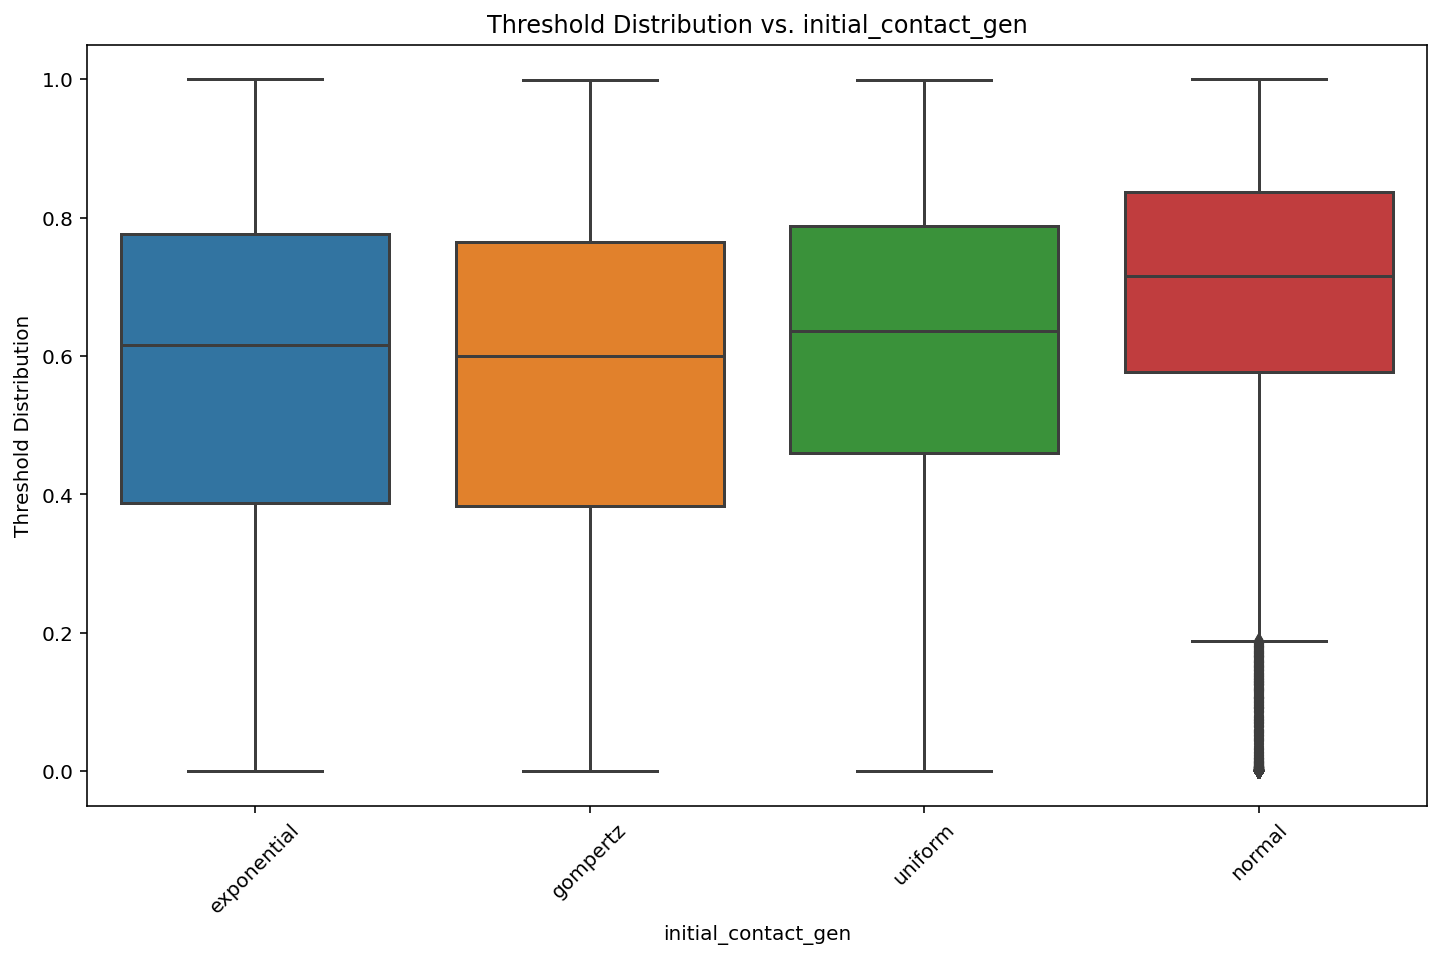

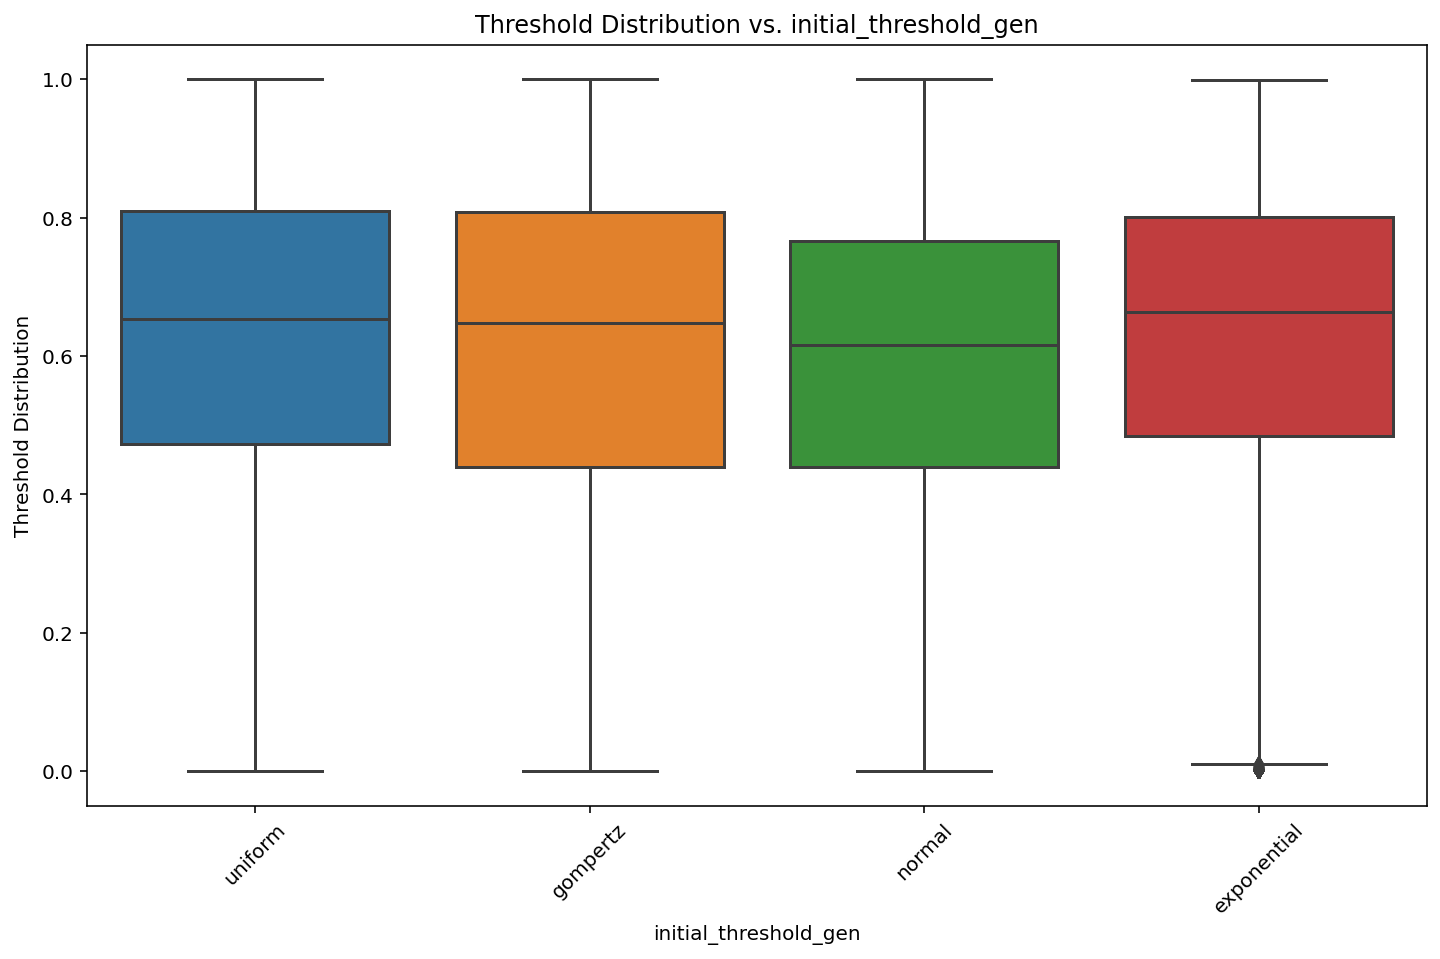


Pearson Correlation and P-value:
attractiveness_gen: correlation=-0.02065, p-value=0.00000, significant=True
decay_rate_gen: correlation=-0.10510, p-value=0.00000, significant=True
threshold_increase_gen: correlation=0.17178, p-value=0.00000, significant=True
initial_contact_gen: correlation=0.09736, p-value=0.00000, significant=True
initial_threshold_gen: correlation=-0.01090, p-value=0.00757, significant=True


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from mesa import Model, Agent
from mesa.time import RandomActivation
from scipy.stats import gompertz, pearsonr


class RandomGen:
    def __init__(self):
        self.distribution = random.choice(["uniform", "normal", "exponential", "gompertz"])

        if self.distribution == "uniform":
            self.args = (0, 1)
            self.func = random.uniform
        elif self.distribution == "normal":
            self.args = (0.5, 0.15)
            self.func = random.normalvariate
        elif self.distribution == "exponential":
            self.args = (0.4,)
            self.func = np.random.exponential
        elif self.distribution == "gompertz":
            self.args = (2,)
            self.func = gompertz.rvs

    def generate(self):
        val = self.func(*self.args)
        return min(max(val, 0), 1)

def plot_results(df):
    # Distribution of threshold values
    plt.figure()
    sns.histplot(data=df, x="threshold_distribution", kde=True)
    plt.title("Threshold Distribution")
    plt.xlabel("Threshold Value")
    plt.ylabel("Frequency")
    plt.show()

    # Boxplot of threshold_distribution vs. variable (one plot for each variable)
    variables = [
        "attractiveness_gen",
        "decay_rate_gen",
        "threshold_increase_gen",
        "initial_contact_gen",
        "initial_threshold_gen",
    ]

    for var in variables:
        plt.figure()
        sns.boxplot(data=df, x=var, y="threshold_distribution")
        plt.title(f"Threshold Distribution vs. {var}")
        plt.xlabel(var)
        plt.ylabel("Threshold Distribution")
        plt.xticks(rotation=45)
        plt.show()

def calculate_correlations(df):
    # Encode the distribution type as numerical values
    encoded_df = df.copy()
    encoded_df['attractiveness_gen'] = encoded_df['attractiveness_gen'].astype('category').cat.codes
    encoded_df['decay_rate_gen'] = encoded_df['decay_rate_gen'].astype('category').cat.codes
    encoded_df['threshold_increase_gen'] = encoded_df['threshold_increase_gen'].astype('category').cat.codes
    encoded_df['initial_contact_gen'] = encoded_df['initial_contact_gen'].astype('category').cat.codes
    encoded_df['initial_threshold_gen'] = encoded_df['initial_threshold_gen'].astype('category').cat.codes

    # Calculate Pearson's correlation coefficients and p-values
    print("\nPearson Correlation and P-value:")
    for var in ['attractiveness_gen', 'decay_rate_gen', 'threshold_increase_gen', 'initial_contact_gen', 'initial_threshold_gen']:
        coef, p_value = pearsonr(encoded_df[var], encoded_df["threshold_distribution"])
        print(f'{var}: correlation={coef:.5f}, p-value={p_value:.5f}, significant={p_value < 0.05}')

def run_simulation(
    num_agents,
    num_steps,
    attractiveness_gen,
    decay_rate_gen,
    threshold_increase_gen,
    initial_contact_gen,
    initial_threshold_gen,
):
    class CustomSocialAgent(Agent):
        def __init__(self, unique_id, model):
            super().__init__(unique_id, model)
            self.attractiveness = attractiveness_gen.generate()
            self.decay_rate = decay_rate_gen.generate() * 0.001
            self.threshold_increase = threshold_increase_gen.generate() * 0.1
            self.initial_contact_threshold = initial_contact_gen.generate()
            self.threshold = initial_threshold_gen.generate()

        def step(self):
            self.threshold -= self.decay_rate
            self.threshold = max(0, self.threshold)

            if random.uniform(0, 1) > self.initial_contact_threshold:
                return

            other_agent = self.random.choice(self.model.schedule.agents)
            if other_agent.attractiveness > self.threshold:
                self.threshold += (other_agent.attractiveness - self.threshold) * self.threshold_increase

    class CustomSocialModel(Model):
        def __init__(self, N):
            self.schedule = RandomActivation(self)
            self.num_agents = N
            for i in range(self.num_agents):
                a = CustomSocialAgent(i, self)
                self.schedule.add(a)

        def step(self):
            self.schedule.step()

    model = CustomSocialModel(num_agents)

    for i in range(num_steps):
        model.step()

    threshold_distributions = [agent.threshold for agent in model.schedule.agents]
    return threshold_distributions


def main():
    columns = [
        "num_agents",
        "num_steps",
        "attractiveness_gen",
        "decay_rate_gen",
        "threshold_increase_gen",
        "initial_contact_gen",
        "initial_threshold_gen",
        "threshold_distribution",
    ]

    all_data = []

    for x in range(200):
        attractiveness_gen = RandomGen()
        decay_rate_gen = RandomGen()
        threshold_increase_gen = RandomGen()
        initial_contact_gen = RandomGen()
        initial_threshold_gen = RandomGen()

        num_agents = 300
        num_steps = 3000

        distributions = run_simulation(
            num_agents,
            num_steps,
            attractiveness_gen,
            decay_rate_gen,
            threshold_increase_gen,
            initial_contact_gen,
            initial_threshold_gen,
        )

        for dist in distributions:
            all_data.append(
                [
                    num_agents,
                    num_steps,
                    attractiveness_gen.distribution,
                    decay_rate_gen.distribution,
                    threshold_increase_gen.distribution,
                    initial_contact_gen.distribution,
                    initial_threshold_gen.distribution,
                    dist,
                ]
            )

    df = pd.DataFrame(all_data, columns=columns)
    plot_results(df)
    calculate_correlations(df)

if __name__ == "__main__":
    main()

